In [11]:
## Install the package if needed:
#install.packages('Rtools', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

Warning message:
"package 'Rtools' is not available (for R version 3.4.1)"

[1] 3

---
# 2. Load and prepare ship data
This section deals with the loading of the met-merge data. Once loaded and the structure is verified, a 2 minute average is taken for all parameters. Once completed, the next section will add the NCEP wind data and MLD to the data frame.The file structure which this script is looking for is as follows where Vars are in any order but with the proper abbreviations.

``Datetime  Var1   Var2  Var3 ...``

Variable Descriptions and Abbreviations
* __DT -- Date Time__
* __TW -- True Wind__
* TI  -- Wind Dir
* __LA -- Latitude__
* __LO -- Longitude__
* __AT -- Atm Temp__
* __BP -- Pressure__
* PA -- PAR
* __TT (TT2*)  -- Water Temp__
* __SA -- Salinity__
* __OS -- Oxygen__
* FL -- Fluorometer
* BT -- Bottom Depth

___NB___: Bold identies required columns while the others are used for additional analyses.

In [6]:
## Load the xlsx file
ship.data = read.xlsx('Raw Data/MET/met-merge-final.xlsx')
colnames(ship.data)

[1] "DT"   "TW"   "TI"   "TT"   "TT-2" "SA"   "OS"   "FL"   "AT"   "BP"  
[11] "BS"   "PR"   "RH"   "RT"   "DP"   "LD"   "LB"   "LT"   "LW"   "SW"  
[21] "PA"   "WS"   "WD"   "WS-2" "WD-2" "TW-2" "TI-2" "TC"   "SA"   "SD"  
[31] "SV"   "TG"   "FI"   "TC-2" "SA-2" "SD-2" "SV-2" "TG-2" "OC"   "OT"  
[41] "OX"   "OS"   "FL"   "FI-2" "VP"   "VR"   "VH"   "VX"   "VY"   "GY"  
[51] "MB"   "BT"   "LF"   "HF"   "LA"   "LO"   "GT"   "CR"   "SP"   "ZD"  
[61] "GA"   "GS"   "ZO"   "ZS"   "ZT"   "ZI"   "ZO-2" "ZS-2" "ZT-2" "ZI-2"
[71] "ZO-3" "ZS-3" "ZT-3" "ZI-3" "PZ"   "PZ-2" "IP"   "IV"   "IA"   "MG"  
[81] "MD"   "MS"   "MG-2" "MD-2" "MS-2" "GC"   "TT-3" "TC-3" "SA-3" "TT-4"
[91] "TC-4" "SA-4" "SH"   "SM"   "SR"   "SL"   "SX"

In [7]:
## Trim data to the following columns:
keep = c('DT', 'TW', 'TI', 'LA', 'LO', 'AT', 'BP', 'PA', 'TT', 'SA', 'OS', 'OX', 'FL', 'BT')
# This call finds which columns match the names in keep and keeps them.
ship.data = ship.data[, which(names(ship.data) %in% keep)]

# Convert excel datetime numbers to actual datetimes.
ship.data$DT = conv_excel_time(ship.data$DT)

# Calculated from Thomas et al.
ship.data$TW = ship.data$TW * 0.942  

## Convert all columns (except date/time to numeric)
for (i in 2:ncol(ship.data)) {
    ship.data[,i] = as.numeric(ship.data[,i])
}

## Check that it loaded properly/correct data type (num)
print(paste('Do the number of names in keep match the number of columns now?', ncol(ship.data) == length(keep)))
str(ship.data)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

[1] "Do the number of names in keep match the number of columns now? FALSE"
'data.frame':	186490 obs. of  17 variables:
 $ DT  : POSIXct, format: "2017-05-30 20:01:00" "2017-05-30 20:01:00" ...
 $ TW  : num  2.54 2.17 2.83 3.01 3.01 ...
 $ TI  : num  209 214 216 224 226 ...
 $ TT  : num  19.4 19.4 19.4 19.4 19.4 ...
 $ SA  : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS  : num  5 5 5 5 5 ...
 $ FL  : num  0.079 0.08 0.077 0.076 0.076 0.077 0.076 0.076 0.076 0.074 ...
 $ AT  : num  16.7 16.7 16.7 16.8 16.8 ...
 $ BP  : num  1010 1010 1010 1010 1010 ...
 $ PA  : num  925 930 918 915 913 ...
 $ SA.1: num  33.2 33.2 33.2 33.2 33.2 ...
 $ OX  : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ OS.1: num  5 5 5 5 5 ...
 $ FL.1: num  0.079 0.08 0.077 0.076 0.076 0.077 0.076 0.076 0.076 0.074 ...
 $ BT  : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ LA  : num  32.7 32.7 32.7 32.7 32.7 ...
 $ LO  : num  -117 -117 -117 -117 -117 ...


#### Remove bad wind data
Here we simply remove the rows there wind speed is less than zero (TW < 0). We also report the number of rows affected (should be a relatively small amount).

In [8]:
bad.wind = which(ship.data$TW < 0)
length(bad.wind)

## Remove bad wind entries
ship.data = ship.data[-bad.wind,]

[1] 618

### The N minute average:
1. Start with the first row, set ___current.time___ to that row's time
2. Find all rows with times >= to the current time
3. Remove all rows with times more than N minutes away from the ___current.time___.
4. Take the column average of those rows and replace the current row.
5. Remove all the other rows
6. Repeat process on the next row.

In [9]:
### N Minute Averaging section
avg.length = 2  # minutes to avg

before = nrow(ship.data)
i = 1
nc = ncol(ship.data)

while (i < nrow(ship.data)) {  # Loop through each row in ship.data
    current.time = ship.data$DT[i]
    
    ## Determine which rows are within N minutes of the current row
    in.range = which(ship.data$DT[1:(i+100)] >= current.time &
                     difftime(ship.data$DT[1:(i+100)], current.time, units='mins') < avg.length)
    
    ##  Average the column values together ignoring the first one (time)
    ship.data[i, 2:nc] = apply(ship.data[in.range, 2:nc], 2, function(x) {mean(x, na.rm = TRUE)})
    
    ## Remove all rows used to make average except for row i
    in.range = in.range[in.range != i]
    if (length(in.range) > 0) {
        ship.data = ship.data[-in.range,]
    }
    i = i + 1
}

print(paste('The number of rows before was', before, 'and now there are', nrow(ship.data)))

[1] "The number of rows before was 185872 and now there are 21209"


## Save Results

In [10]:
## Save point after loading ship data and averaging. 
save(ship.data, file='./RStates/ship.avg.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - Averaged.xlsx')

gc() # Free up memory

ERROR: Error: zipping up workbook failed. Please make sure Rtools is installed or a zip application is available to R.
         Try installr::install.rtools() on Windows. If the "Rtools\bin" directory does not appear in Sys.getenv("PATH") please add it to the system PATH 
         or set this within the R session with Sys.setenv("R_ZIPCMD" = "path/to/zip.exe")


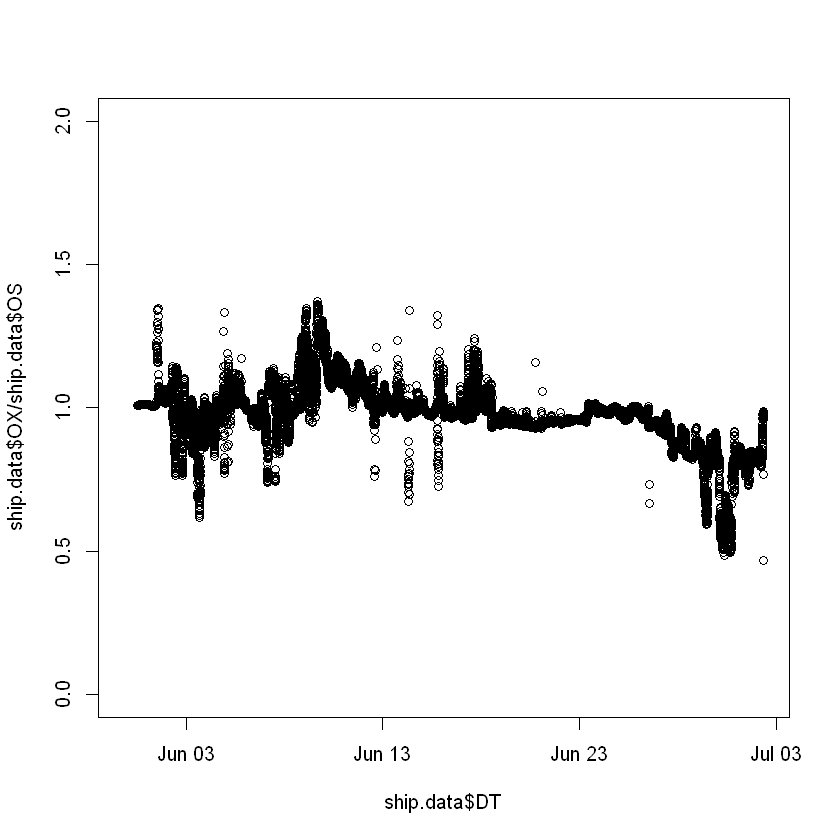

In [12]:
plot(ship.data$DT, ship.data$OX / ship.data$OS, ylim=c(0,2))